# Final Project 2023-2024 - Rock-Paper-Scissors Agent

Author: Georgios Fesatidis \
Email: gfesa@csd.auth.gr \

# Setup Environment

## Download Dataset from Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp ./drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

drive.flush_and_unmount()

In [3]:
import kaggle

!mkdir -p rockpaperscissors
!kaggle datasets download -p rockpaperscissors --unzip drgfreeman/rockpaperscissors
!rm -rf rockpaperscissors/rps-cv-images rockpaperscissors/README_rpc-cv-images.txt

 97% 298M/306M [00:03<00:00, 109MB/s]
100% 306M/306M [00:03<00:00, 96.9MB/s]


## Install Libraries

In [4]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.7 MB/s eta 0:00:00


## Import Libraries

In [30]:
import pathlib

from typing import Protocol
from enum import Enum

from google.colab import files

import matplotlib.pyplot as plt
import matplotlib
import gymnasium as gym
import seaborn as sns
import numpy as np
import keras
import sklearn
import tensorflow as tf

from keras import layers
from sklearn.metrics import confusion_matrix
from gym.envs.registration import register
from gym import spaces

In [35]:
!python -V

print(f'tensorflow: {tf.__version__}')
print(f'keras: {keras.__version__}')
print(f'gymnasium: {gym.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'numpy: {np.__version__}')
print(f'scikit-learn: {sklearn.__version__}')

Python 3.10.12
tensorflow: 2.15.0
keras: 2.15.0
gymnasium: 0.29.1
matplotlib: 3.7.1
seaborn: 0.13.1
numpy: 1.23.5
scikit-learn: 1.2.2


## Assign Variables

In [ ]:
rng = np.random.default_rng()
seed = 47

img_width = 32
img_height = 32
img_channels = 3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Laod Dataset

In [ ]:
dataset_path = pathlib.Path('rockpaperscissors')
dataset_path

PosixPath('rockpaperscissors')

In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(dataset_path, image_size=(img_width, img_height), validation_split=0.3, subset='both', crop_to_aspect_ratio=True, seed=seed)

Found 2188 files belonging to 3 classes.
Using 1532 files for training.
Using 656 files for validation.


## Define Classes

In [ ]:
class RockPaperScissorsModel(Protocol):
    '''
    Protocol defining the common interface for Rock-Paper-Scissors image classification models.
    '''
    best_actions: dict

    def __init__(self) -> None:
        ...

    def call(self, inputs: np.ndarray) -> layers.Dense:
        ...

class RPS(Enum):
    PAPER = 0
    ROCK = 1
    SCISSORS = 2

## Define Functions

In [ ]:
def get_image_path(action: int) -> pathlib.Path:
    class_directory = train_ds.class_names[action]
    class_path = dataset_path / class_directory
    images = list(class_path.glob('*.png'))

    return rng.choice(images)

def add_noise(image: np.ndarray) -> np.ndarray:
    # Calculate the standard deviation based on 5% of the maximum pixel value
    max_pixel_value = np.max(image)
    noise_std_dev = 0.05 * max_pixel_value

    noise = rng.normal(scale=noise_std_dev, size=image.shape)
    noisy_image = image + noise

    # Clip values to ensure they stay within the valid pixel value range
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image

def random_flip(image: np.ndarray) -> np.ndarray:
    if rng.random() > 0.5:
        image = np.flipud(image)
    if rng.random() > 0.5:
        image = np.fliplr(image)

    return image

def preprocess_image(image: np.ndarray) -> np.ndarray:
    image_arr = keras.utils.img_to_array(image)
    image_arr = keras.layers.Resizing(32, 32, crop_to_aspect_ratio=True)(image_arr)
    image_arr = layers.Rescaling(scale=1./255)(image_arr)
    # Convert single image to a batch.
    image_arr = np.array([image_arr])

    return image_arr

def start_simulation(model: RockPaperScissorsModel) -> tuple[list[int], list[int]]:
    env = RockPaperScissorsEnv()

    true_labels = []
    predicted_labels = []

    for _ in range(env.max_episodes):
        observation = env.reset()
        action = model.predict(observation)
        action_idx = action.argmax()

        true_labels.append(env.state)
        predicted_labels.append(action_idx)

        best_action = model.best_actions[action_idx]
        observation, reward = env.step(best_action)

    return true_labels, predicted_labels, env

# Dataset Analysis

In [ ]:
counts = [len(list(dataset_path.glob(f'{class_name}/*'))) for class_name in train_ds.class_names]
print(f'Total number of images: {sum(counts)}')

Total number of images: 2188


The dataset is imbalanced, with the dominant class being scissors. While there isn't a significant difference in the examples between the classes, techniques like data augmentation could be employed to balance them. However, for testing purposes, we will proceed without any conversion.

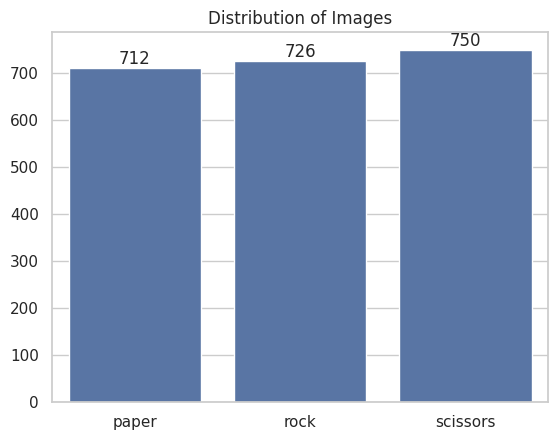

In [ ]:
sns.set(style="whitegrid")

ax = sns.barplot(x=train_ds.class_names, y=counts)
for i, count in enumerate(counts):
    ax.text(i, count + 0.1, count, ha='center', va='bottom')
ax.set_title('Distribution of Images')
plt.show()

Sample images from the dataset.

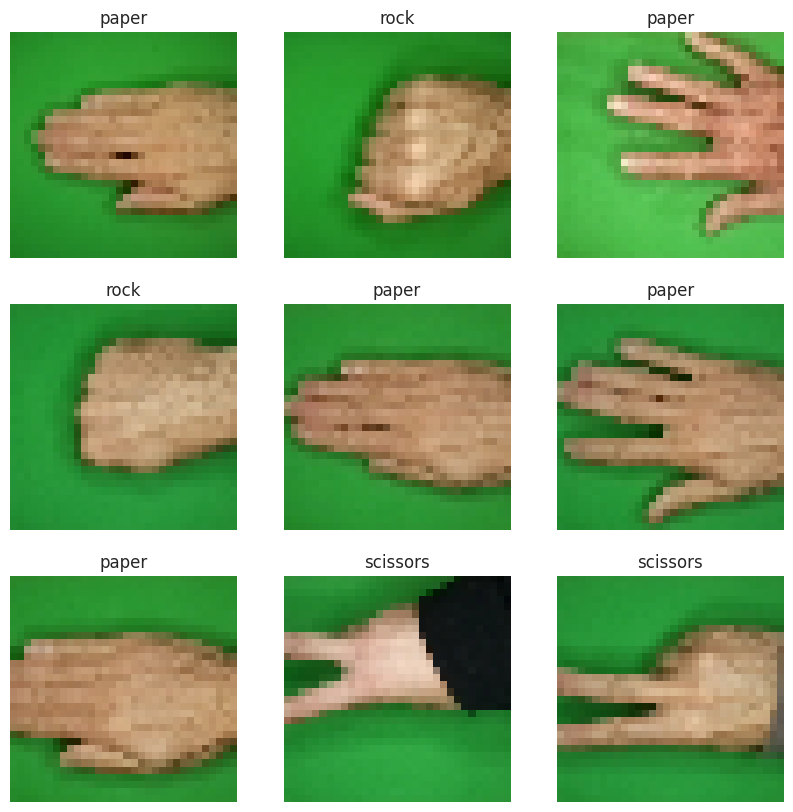

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

# Rock-Scissors-Paper Models

The Rock-Paper-Scissors image classification task will be addressed using two distinct neural network architectures. The first model, a Convolutional Neural Network (CNN), leverages convolutional and pooling layers to automatically learn hierarchical features from the input images. The second model, a Feedforward Neural Network (MLP), employs fully connected layers for feature representation. Both models are designed to classify images into one of three classes: Rock, Paper, or Scissors, based on the iconic hand game.

## Feedforward Neural Network

In [ ]:
class RockPaperScissorsFeedforwardModel(keras.Model):
    '''
    Feedforward Neural Network for Rock-Paper-Scissors Image Classification.

    This model is designed to classify images into one of three classes: Rock, Paper, or Scissors,
    based on the popular hand game. It follows a feedforward neural network (MLP) architecture.

    Attributes:
        preprocessing (tf.keras.layers.experimental.preprocessing.Rescaling): Normalization layer
            for rescaling input pixel values.
        flatten (tf.keras.layers.Flatten): Flatten layer to convert 2D feature maps to a 1D vector.
        dense1 (tf.keras.layers.Dense): First fully connected layer with 128 units and ReLU activation.
        dense2 (tf.keras.layers.Dense): Second fully connected layer with 64 units and ReLU activation.
        output_layer (tf.keras.layers.Dense): Output layer with 3 units for Rock, Paper, and Scissors,
            using softmax activation for multi-class classification.

    Methods:
        call(inputs): Defines the forward pass of the model.

    Example:
        # Instantiate the feedforward model
        feedforward_model = RockPaperScissorsFeedforwardModel()

        # Compile the model
        feedforward_model.compile(optimizer='adam',
                                  loss='sparse_categorical_crossentropy',
                                  metrics=['accuracy'])

        # Display the model summary
        feedforward_model.build((None, 64, 64, 3))  # Specify input shape
        feedforward_model.summary()

        # Train the model
        feedforward_model.fit(train_ds, epochs=10, validation_data=val_ds)
    '''

    def __init__(self) -> None:
        super().__init__()

        self.best_actions = {
            RPS.PAPER.value: RPS.SCISSORS.value,
            RPS.ROCK.value: RPS.PAPER.value,
            RPS.SCISSORS.value: RPS.ROCK.value
        }

        self.preprocessing = layers.experimental.preprocessing.Rescaling(scale=1/255)
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(3, activation='softmax')

    def call(self, inputs: np.ndarray) -> layers.Dense:
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.output_layer(x)

In [ ]:
feedforward_model = RockPaperScissorsFeedforwardModel()
feedforward_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
feedforward_model.build(input_shape=(None, img_width, img_height, img_channels))

### Architecture

In [ ]:
feedforward_model.summary()

Model: "rock_paper_scissors_feedforward_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0 (unused)
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  393344    
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  195       
                                                                 
Total params: 401795 (1.53 MB)
Trainable params: 401795 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________________

### Training

In [ ]:
history = feedforward_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
48/48 [==============================] - 10s 147ms/step - loss: 96.9562 - accuracy: 0.5059 - val_loss: 6.9288 - val_accuracy: 0.7317
Epoch 2/20
48/48 [==============================] - 5s 74ms/step - loss: 7.5031 - accuracy: 0.7004 - val_loss: 7.1737 - val_accuracy: 0.6814
Epoch 3/20
48/48 [==============================] - 5s 107ms/step - loss: 6.1958 - accuracy: 0.7493 - val_loss: 5.2282 - val_accuracy: 0.7012
Epoch 4/20
48/48 [==============================] - 4s 67ms/step - loss: 4.2885 - accuracy: 0.7892 - val_loss: 5.6928 - val_accuracy: 0.7622
Epoch 5/20
48/48 [==============================] - 4s 73ms/step - loss: 10.6937 - accuracy: 0.7037 - val_loss: 3.9740 - val_accuracy: 0.8506
Epoch 6/20
48/48 [==============================] - 5s 89ms/step - loss: 4.3369 - accuracy: 0.8087 - val_loss: 4.5064 - val_accuracy: 0.8171
Epoch 7/20
48/48 [==============================] - 4s 67ms/step - loss: 1.8804 - accuracy: 0.8916 - val_loss: 2.9179 - val_accuracy: 0.8476
Epoch 8/

1. **Loss:**
   - The training loss is decreasing over epochs, which is a positive sign, indicating that the model is learning from the training data.
   - The validation loss also shows a decreasing trend initially but starts to increase again after a certain point. This could be a sign of overfitting, where the model is fitting the training data too closely and may not generalize well to new, unseen data.

2. **Accuracy:**
   - The training accuracy is gradually increasing, indicating that the model is becoming better at predicting the training data.
   - The validation accuracy is also increasing initially but plateaus and even decreases towards the later epochs. This is another indication of potential overfitting.

3. **Observations:**
   - The model seems to perform well on the training set, achieving high accuracy and low loss.
   - However, there are signs of overfitting as the validation accuracy does not follow the same positive trend, and the validation loss starts to increase.
   - The difference between training and validation performance suggests that the model might benefit from regularization techniques to improve generalization.

4. **Specific Epochs:**
   - Notably, the validation accuracy peaks around epoch 15 and starts declining afterward, while the training accuracy continues to improve. This is a classic sign of overfitting.
   - The validation loss is at its minimum around epoch 14 but increases in subsequent epochs.

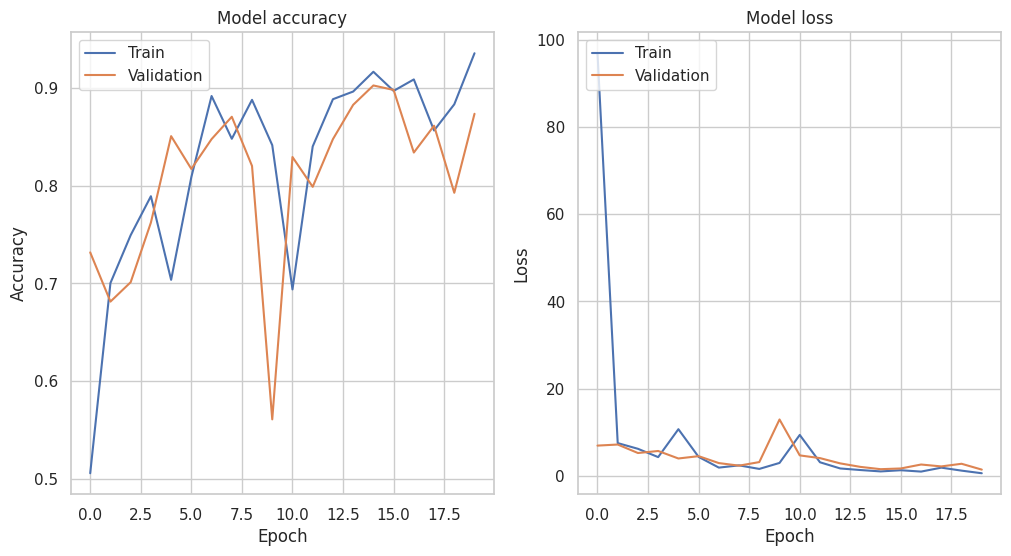

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Convolutional Neural Network

In [ ]:
class RockPaperScissorsCNNModel(keras.Model):
    '''
    Convolutional Neural Network for Rock-Paper-Scissors Image Classification.

    This model is designed to classify images into one of three classes: Rock, Paper, or Scissors,
    based on the popular hand game. It follows a simple CNN architecture for image classification.

    Attributes:
        preprocessing (tf.keras.layers.Rescaling): Normalization layer for rescaling input pixel values.
        conv1 (tf.keras.layers.Conv2D): First convolutional layer with 32 filters and ReLU activation.
        maxpool1 (tf.keras.layers.MaxPooling2D): First max pooling layer with 2x2 pool size.
        conv2 (tf.keras.layers.Conv2D): Second convolutional layer with 64 filters and ReLU activation.
        maxpool2 (tf.keras.layers.MaxPooling2D): Second max pooling layer with 2x2 pool size.
        flatten (tf.keras.layers.Flatten): Flatten layer to convert 2D feature maps to a 1D vector.
        dense1 (tf.keras.layers.Dense): Fully connected layer with 128 units and ReLU activation.
        output_layer (tf.keras.layers.Dense): Output layer with 3 units for Rock, Paper, and Scissors,
                                              using softmax activation for multi-class classification.

    Methods:
        call(inputs): Defines the forward pass of the model.

    Example:
        model = RockPaperScissorsModel()
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(train_ds, epochs=10, validation_data=val_ds)
    '''

    def __init__(self) -> None:
        super().__init__()

        self.best_actions = {
            RPS.PAPER.value: RPS.SCISSORS.value,
            RPS.ROCK.value: RPS.PAPER.value,
            RPS.SCISSORS.value: RPS.ROCK.value
        }

        self.preprocessing = layers.Rescaling(scale=1/255)
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu')
        self.maxpool1 = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')
        self.maxpool2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.output_layer = layers.Dense(3, activation='softmax')

    def call(self, inputs: np.ndarray) -> layers.Dense:
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.output_layer(x)

In [ ]:
cnn_model = RockPaperScissorsCNNModel()
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
cnn_model.build(input_shape=(None, img_width, img_height, img_channels))

### Architecture

In [ ]:
cnn_model.summary()

Model: "rock_paper_scissors_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     multiple                  0 (unused)
                                                                 
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         multiple

### Training

In [ ]:
history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
48/48 [==============================] - 7s 103ms/step - loss: 4.5172 - accuracy: 0.7441 - val_loss: 0.2723 - val_accuracy: 0.9009
Epoch 2/20
48/48 [==============================] - 6s 103ms/step - loss: 0.1502 - accuracy: 0.9491 - val_loss: 0.1119 - val_accuracy: 0.9634
Epoch 3/20
48/48 [==============================] - 5s 101ms/step - loss: 0.0696 - accuracy: 0.9778 - val_loss: 0.1380 - val_accuracy: 0.9649
Epoch 4/20
48/48 [==============================] - 5s 97ms/step - loss: 0.0631 - accuracy: 0.9791 - val_loss: 0.1126 - val_accuracy: 0.9680
Epoch 5/20
48/48 [==============================] - 6s 121ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0577 - val_accuracy: 0.9787
Epoch 6/20
48/48 [==============================] - 5s 98ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0642 - val_accuracy: 0.9741
Epoch 7/20
48/48 [==============================] - 7s 142ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9771
Epoch 8/

1. **Loss:**
   - The training loss starts relatively high at epoch 1 but decreases significantly, indicating that the model is learning from the training data.
   - The validation loss is low and shows a stable trend, suggesting that the model is performing well on unseen data.

2. **Accuracy:**
   - The training accuracy starts at a high value and quickly approaches 1.0 (100%), indicating that the model is fitting the training data very well.
   - The validation accuracy also starts high and remains stable, suggesting that the model generalizes well to new, unseen data.

3. **Observations:**
   - Both training and validation metrics show excellent performance, with the model achieving very low loss and high accuracy.
   - The model appears to converge well, as indicated by the consistent and high accuracy values on both training and validation sets.

4. **Specific Epochs:**
   - The model achieves near-perfect accuracy on both training and validation sets, indicating that it has successfully learned the patterns in the data.
   - The loss values for both sets continue to decrease, showing the model's ability to minimize errors.

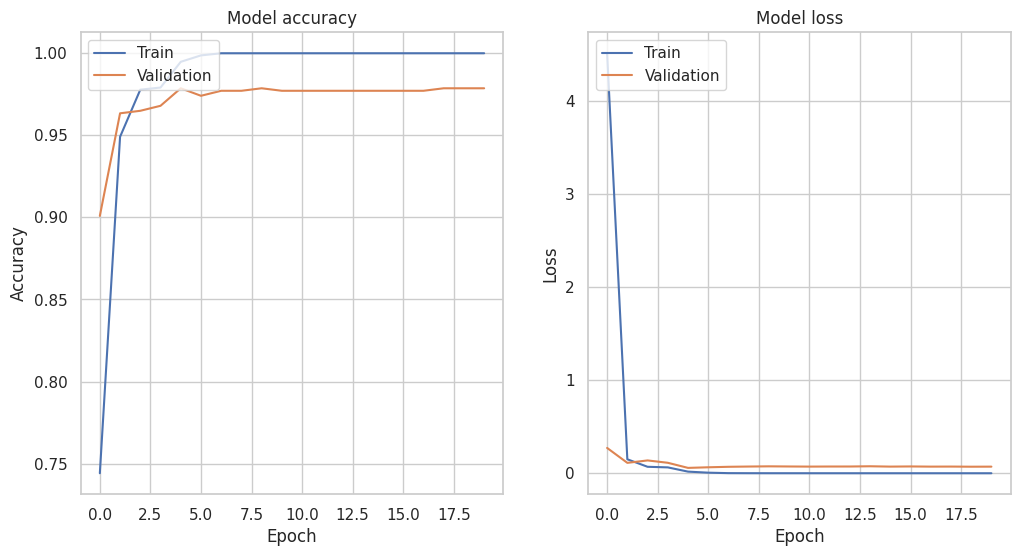

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Model choice

Among the two models, the convolutional neural network exhibits superior performance, both in terms of validation and train set results. This will be our chosen model for the final solution. However, for testing purposes, we will also include the simple feedforward neural network.

# Rock-Scissors-Paper Environment

In [ ]:
class RockPaperScissorsEnv(gym.Env):
    '''
    Custom Gym environment for a Rock-Paper-Scissors game with images.

    This environment simulates a Rock-Paper-Scissors game where the agent
    receives images corresponding to Rock, Paper, or Scissors actions and
    attempts to "learn" optimal strategies based on the rewards associated
    with each action-state pair.

    Parameters:
    - max_episodes (int): Maximum number of episodes for training. Defaults to 300.

    Observation Space:
    The observation space is a 32x32x3 image representing the current game state.

    Action Space:
    The action space consists of three discrete actions:
    - 0: Paper
    - 1: Rock
    - 2: Scissors

    Rewards:
    The reward matrix is predefined as follows:
    - Paper vs. Paper: 0, Paper vs. Rock: 1, Paper vs. Scissors: -1
    - Rock vs. Paper: -1, Rock vs. Rock: 0, Rock vs. Scissors: 1
    - Scissors vs. Paper: 1, Scissors vs. Rock: -1, Scissors vs. Scissors: 0

    Methods:
    - _get_image(): Generates a random image corresponding to a sampled action.
    - reset(seed=None, options=None): Resets the environment to a new episode, returning the preprocessed initial state.
    - step(action): Executes the given action, returning the next state, reward, and episode termination information.

    Attributes:
    - action_space: Discrete space representing the possible actions.
    - observation_space: Box space representing the image observation.
    - max_episodes: Maximum number of episodes for training.
    - total_wins: Total number of wins accumulated across episodes.
    - wins: List of rewards obtained in each episode.
    - image: Current image representing the game state.
    - state: Current state corresponding to the last selected action.
    '''

    def __init__(self, max_episodes: int = 300) -> None:
        super().__init__()

        self.reward = np.array([[0, 1, -1],
                                [-1, 0, 1],
                                [1, -1, 0]])

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(img_width, img_height, img_channels))
        self.max_episodes = max_episodes
        self.total_wins = 0
        self.wins = []
        self.image = None
        self.state = None

    def _get_image(self) -> np.ndarray:
        action = self.action_space.sample()
        random_image_path = get_image_path(action)
        image = keras.utils.load_img(random_image_path)
        image_arr = preprocess_image(image)

        return image_arr, action

    def reset(self, seed=None, options=None) -> np.ndarray:
        self.image, self.state = self._get_image()
        self.image = random_flip(self.image)
        return add_noise(self.image)

    def step(self, action: int) -> tuple:
        reward = self.reward[action, self.state]
        self.wins.append(reward)

        if reward > 0:
            self.total_wins += 1

        next_state = self.image

        return self.image, reward

# Simulation

## Convolutional Neural Network

In [ ]:
true_labels, predicted_labels, env = start_simulation(cnn_model)

1/1 [==============================] - 0s 23ms/step


We observe quite accurate predictions from the convolutional neural network, achieving perfect predictions for the rock class. However, it mistakenly classified five images of the paper class as rock, and for the scissors class, it confused two images as paper and three images as rock.

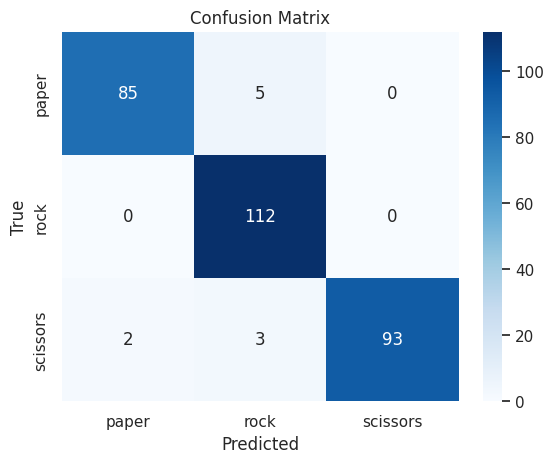

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

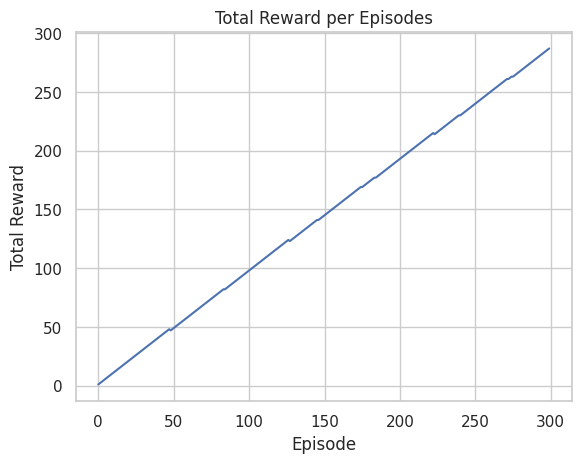

In [ ]:
plt.plot(np.cumsum(env.wins))
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episodes')
plt.show()

In [ ]:
print(f'The model won {env.total_wins} out of {env.max_episodes} episodes')

The model won 290 out of 300 episodes


## Feedforward Neural Network

In [ ]:
true_labels, predicted_labels, env = start_simulation(feedforward_model)

1/1 [==============================] - 0s 22ms/step


The feedforward model performed slightly less accurately than the convolutional model, but overall, it still achieved commendable results. Notably, for the paper class, it misclassified 5 images as stone and 23 as scissors. For the rock class, it confused 2 images as paper and 6 as scissors. Finally, for the scissors class, it misclassified 1 image as paper and 1 as rock.

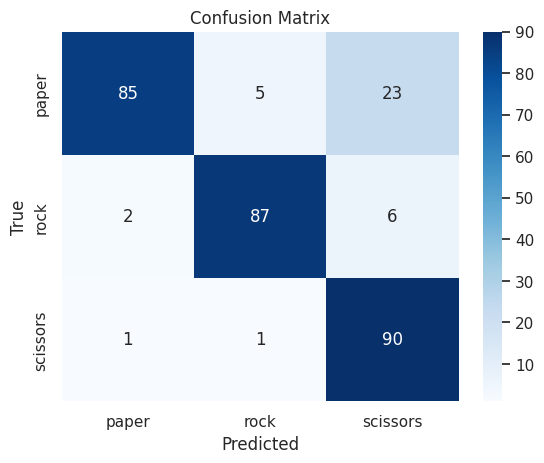

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

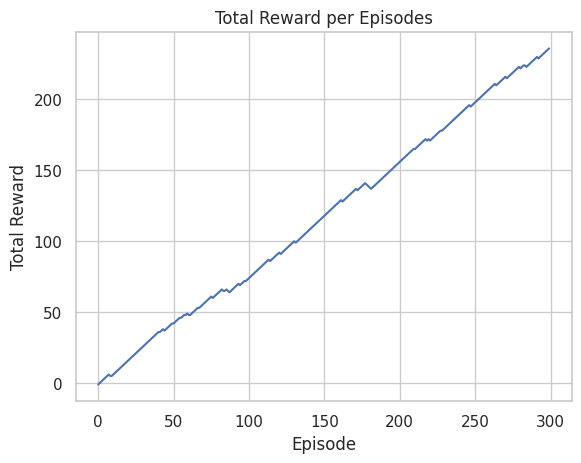

In [ ]:
plt.plot(np.cumsum(env.wins))
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episodes')
plt.show()

In [ ]:
print(f'The model won {env.total_wins} out of {env.max_episodes} episodes')

The model won 262 out of 300 episodes


# Extra Testing

Test the models on an image that is not present in the dataset to evaluate their generalization performance.

In [ ]:
uploaded = files.upload()
image_name = list(uploaded.keys())[0]

Saving test.png to test.png


In [ ]:
image = keras.utils.load_img(image_name)
image_arr = preprocess_image(image)

In [ ]:
action = cnn_model.predict(image_arr)
action_idx = action.argmax()

print(f'The CNN model predicted: {train_ds.class_names[action_idx]}')
print(f'The CNN model\'s optimal move: {train_ds.class_names[cnn_model.best_actions[action_idx]]}')

1/1 [==============================] - 0s 49ms/step
The CNN model predicted: paper
The CNN model's optimal move: scissors


In [ ]:
action = feedforward_model.predict(image_arr)
action_idx = action.argmax()

print(f'The Feedforward model predicted: {train_ds.class_names[action_idx]}')
print(f'The Feedforward model\'s optimal move: {train_ds.class_names[feedforward_model.best_actions[action_idx]]}')

1/1 [==============================] - 0s 23ms/step
The Feedforward model predicted: scissors
The Feedforward model's optimal move: rock


We observe that the feedforward model successfully predicted the image and selected the optimal action, whereas the convolutional neural network did not, despite performing better in the simulation.